In [1]:
import csv
import numpy

In [2]:
train_data = numpy.loadtxt("galaxies_train.csv", delimiter=",", skiprows=1)
test_data = numpy.loadtxt("galaxies_test.csv", delimiter=",", skiprows=1)

In [3]:
X_train = train_data[:,1:]
t_train = train_data[:,0]
X_test = test_data[:,1:]
t_test = test_data[:,0]
t_train = t_train.reshape((len(t_train),1))
t_test = t_test.reshape((len(t_train),1))
print("Number of training instances: %i" % X_train.shape[0])
print("Number of test instances: %i" % X_test.shape[0])
print("Number of attributes: %i" % X_train.shape[1])

Number of training instances: 500
Number of test instances: 500
Number of attributes: 10


In [4]:
class LinearRegression():
    """
    Linear regression implementation.
    """

    def __init__(self, lam=0.0):
        
        self.lam = lam
            
    def fit(self, X, t):
        """
        Fits the linear regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of shape [n_samples, 1]
        """        

        # make sure that we have Numpy arrays; also
        # reshape the target array to ensure that we have
        # a N-dimensional Numpy array (ndarray), see
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.ndarray.html
        X = numpy.array(X).reshape((len(X), -1))
        t = numpy.array(t).reshape((len(t), 1))

        # prepend a column of ones
        ones = numpy.ones((X.shape[0], 1))
        X = numpy.concatenate((ones, X), axis=1)
        
        # compute weights (solve system)
        diag = self.lam * len(X) * numpy.identity(X.shape[1])
        a = numpy.dot(X.T, X) + diag
        b = numpy.dot(X.T, t)
        self.w = numpy.linalg.solve(a,b)    
                
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of shape [n_samples, 1]
        """                     

        # make sure that we have Numpy arrays; also
        # reshape the target array to ensure that we have
        # a N-dimensional Numpy array (ndarray), see
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.ndarray.html
        X = numpy.array(X).reshape((len(X), -1))

        # prepend a column of ones
        ones = numpy.ones((X.shape[0], 1))
        X = numpy.concatenate((ones, X), axis=1)           

        # compute predictions
        predictions = numpy.dot(X, self.w)

        return predictions


In [5]:
class NearestNeighborRegressor:
    
    def __init__(self, n_neighbors=1, dist_measure="euclidean", dist_matrix=None):
        """
        Initializes the model.
        
        Parameters
        ----------
        n_neighbors : The number of nearest neigbhors (default 1)
        dist_measure : The distance measure used (default "euclidean")
        dist_matrix : The distance matrix if needed (default "None")
        """        
        self.n_neighbors = n_neighbors
        self.dist_measure = dist_measure
        self.dist_matrix = dist_matrix
    
    def fit(self, X, t):
        """
        Fits the nearest neighbor regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of length n_samples
        """ 
        
        self.X_train = X
        self.t_train = t
    
    def get_neighbours(self, x):
        """
        Computes the nearest neighbors for a query point

        Parameters
        ----------
        x : Array of shape [1, n_features]

        Returns
        -------
        indices : The k nearest neigbhors (indices) for x.
        """    
        
        dists = []

        for j in range(len(self.X_train)):

            if self.dist_measure == "euclidean":
                d = self._euclideanDistance(x, self.X_train[j])
            elif self.dist_measure == "matrix":
                d = self._matrixDistance(x, self.X_train[j])
            else:
                raise Exception("Unknown distance measure!")

            dists.append(d)

        # sort distances and return corresponding indices
        sorted_indices = numpy.argsort(dists)
        best_k_indices = sorted_indices[:self.n_neighbors]

        return best_k_indices
        
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of length n_samples
        """         
        
        predictions = []
        
        for i in range(len(X)):
            
            dists = []
            
            for j in range(len(self.X_train)):
                
                if self.dist_measure == "euclidean":
                    d = self._euclideanDistance(X[i], self.X_train[j])
                elif self.dist_measure == "matrix":
                    d = self._matrixDistance(X[i], self.X_train[j])
                else:
                    raise Exception("Unknown distance measure!")

                dists.append(d)
            
            # sort distances and return corresponding indices
            sorted_indices = numpy.argsort(dists)
            best_k_indices = sorted_indices[:self.n_neighbors]
            
            # compute prediction via the mean of the label
            pred = self.t_train[best_k_indices].mean()
            predictions.append(pred)
            
        predictions = numpy.array(predictions)
        
        return predictions, best_indices
    
    def _euclideanDistance(self, p, q):
        """
        Computes the Euclidean distance between 
        two points.
        """
        
        d = ((q - p)**2).sum()
        d = numpy.sqrt(d)
        
        return d

    def _matrixDistance(self, p, q):
        """
        Computes the distance between 
        two points via the pre-defined matrix.
        """
        
        if self.dist_matrix is None:
            raise Exception("Distance matrix must not be None!")
        
        q = numpy.array(q).reshape((len(q),1))
        p = numpy.array(p).reshape((len(p),1))
        diff = q-p
        
        d = numpy.dot(diff.T, self.dist_matrix)
        d = numpy.dot(d, diff)

        return d[0,0]
    
def rmse(t, tp):
    """ Computes the RMSE for two
    input arrays 't' and 'tp'.
    """

    # sanity check: both shapes have to be the same!
    assert tp.shape == t.shape

    return numpy.sqrt(numpy.mean((t - tp)**2))

In [6]:
class LocallyLinearRegression():
    """
    Locally linear regression implementation.
    """

    def __init__(self, n_neighbors=10):
        """ Constructor for model.

        Parameters
        ----------
        n_neighbors : int
            The number of nearest neighbors
        """
        
        self.n_neighbors = n_neighbors
            
    def fit(self, X, t):
        """
        Fits the linear regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of shape [n_samples, 1]
        """        
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray)
        self.X_train = numpy.array(X).reshape((X.shape[0], -1))
        self.t_train = numpy.array(t).reshape((len(t),1))
        
        # initialize NN model
        self._nn_model = NearestNeighborRegressor(n_neighbors=self.n_neighbors)
        self._nn_model.fit(self.X_train, self.t_train)
                
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of shape [n_samples, 1]
        """                     

        preds = []
        
        for x in X:
            
            x = x.reshape((1,-1))
            best_k_indices = self._nn_model.get_neighbours(x)
            X_local = self.X_train[best_k_indices,:]
            t_local = self.t_train[best_k_indices]
            
            # fit local linear model
            local_model = LinearRegression(lam=1.0)
            local_model.fit(X_local, t_local)
            
            # get prediction
            pred = local_model.predict(x)
            preds.append(pred[0])
        
        return numpy.array(preds)

In [7]:
def rmse(t, tp):
    """ Computes the RMSE for two
    input arrays 't' and 'tp'.
    """

    # sanity check: both shapes have to be the same!
    assert tp.shape == t.shape

    return numpy.sqrt(numpy.mean((t - tp)**2))

# fit model on training instances
model = LocallyLinearRegression(n_neighbors=15)
model.fit(X_train, t_train)

# get predictions on test set
preds = model.predict(X_test)

error = rmse(t_test, preds)
print("RMSE of locally linear model model on test set: %f" % error)

RMSE of locally linear model model on test set: 0.892577


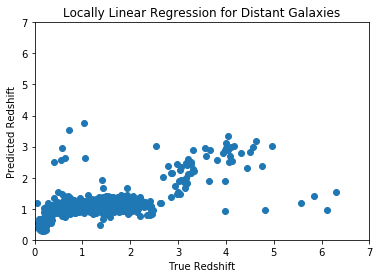

In [9]:
import matplotlib.pyplot as plt

plt.scatter(t_test, preds)
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Locally Linear Regression for Distant Galaxies")
plt.xlim([0,7])
plt.ylim([0,7])
#plt.legend()
plt.show()